Initialize the LLM and embedding model.

In [1]:
!pip install -qU langchain langchain-core  langchain-community  langchain-couchbase langgraph    beautifulsoup4 langchain_cohere langchain-ollama pypdf

In [2]:
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
llm = ChatOllama(model="llama3.1",temperature=0,)

embeddings = OllamaEmbeddings(
    model="llama3.1",
)

In [3]:

from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.document_loaders.couchbase import CouchbaseLoader
from langgraph.prebuilt import ToolNode, tools_condition

Define a function to convert document into vector and save it to couchbase vector db

In [4]:
file_path = "/Users/henrypotsangbam/Documents/Software/data/server-arc-overview.pdf"
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
def save_file(file, cb_store):
    
    loader = PyPDFLoader(file)
    pages = loader.load_and_split()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000,
        chunk_overlap=10,
        length_function=len,
    )

    docs = text_splitter.split_documents(pages)
    for doc in docs:
        print("loaded:", doc)
    cb_store.add_documents(docs)    

Configure couchbase cluster information

In [5]:
COUCHBASE_CONNECTION_STRING = "couchbase://localhost"
DB_USERNAME = "Administrator"
DB_PASSWORD = "admin123"

from datetime import timedelta

from couchbase.auth import PasswordAuthenticator
from couchbase.cluster import Cluster
from couchbase.options import ClusterOptions

auth = PasswordAuthenticator(DB_USERNAME, DB_PASSWORD)
options = ClusterOptions(auth)
cluster = Cluster(COUCHBASE_CONNECTION_STRING, options)

# Wait until the cluster is ready for use.
cluster.wait_until_ready(timedelta(seconds=5))

BUCKET_NAME = "knowledge_bucket"
SCOPE_NAME = "knowledge"
COLLECTION_NAME = "manual"
SEARCH_INDEX_NAME = "vector-index"


from langchain_couchbase.vectorstores import CouchbaseVectorStore

vector_store = CouchbaseVectorStore(
    cluster=cluster,
    bucket_name=BUCKET_NAME,
    scope_name=SCOPE_NAME,
    collection_name=COLLECTION_NAME,
    embedding=embeddings,
    index_name=SEARCH_INDEX_NAME,
    text_key="text",
    embedding_key="embedding",
)

In [6]:
# Upload the document vector into the couchbase vector db
save_file(file_path,vector_store)

loaded: page_content='Couchbase Under the Hood
An Architectural Overview' metadata={'source': '/Users/henrypotsangbam/Documents/Software/data/server-arc-overview.pdf', 'page': 0}
loaded: page_content='Couchbase Under the Hood
An Architectural Overview
Table of Contents
INTRODUCTION 3
Essential NoSQL requirements and features 3
Core design principles 5
JSON DATA MODEL AND ACCESS METHODS 5
JSON data model 5
Document access methods 7
Keys, values, and sub-documents 8
Key Couchbase concepts 9
COUCHBASE SERVICES 9
Data service and KV engine 10
Key-value data access 12
Query service 13
Index service for N1QL 14
Search service 15
Eventing service 16
Analytics 16
Mobile 17
DISTRIBUTED FOUNDATION 18
Node-level architecture 18
Cluster architecture 19
Client connectivity 20
Data transport via Database Change Protocol (DCP) 21
Multi-Dimensional Scaling (MDS) 22
Data distribution 23
Rebalancing the cluster 24
High availability 24
Security 29
Mobile client synchronization 30
RESOURCES 32' metadata={

Define the SQL tools

In [7]:
# Define the tools for the agent to use
@tool
def searchSQL(id:int):
    """Call to fetch document from the bucket, travel-sample."""
    # This is a placeholder ...
    #print(">>>",query)
    query = "select * from `travel-sample`.inventory.airline where airline.id=" + str(id)
    loader = CouchbaseLoader(
        COUCHBASE_CONNECTION_STRING,
        DB_USERNAME,
        DB_PASSWORD,
        query,
    )
    docs = loader.load()
    return docs


Define Vector Search Tools

In [8]:
@tool
def tools_cb_vector(query:str) :
    """
      Explain about couchbase architecture using couchbase vector search 
    
    """
    results = vector_store.similarity_search(
        query,k=2,)
    return results

In [9]:
results = vector_store.similarity_search(
    "Explain Couchbase Under the Hood ",
    k=2,
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* Couchbase Under the Hood
An Architectural Overview [{}]
* Couchbase Mobile brings the power of a NoSQL database to the edge. It includes 
Couchbase Lite , an embedded NoSQL JSON document store that supports a SQL-based 
query API, and Sync Gateway , a synchronization gateway responsible for synchronizing 
data across clients and the cloud, and for enforcing access control policies, authentication, 
authorization, and data routing. With Couchbase Mobile you can build offline-first mobile 
applications that are responsive and always available with enterprise-grade end-to-end 
security and scalability. [{}]


Configure the tools node.

In [10]:
tools = [searchSQL, tools_cb_vector]
tool_node = ToolNode(tools)
model = llm.bind_tools(tools)

In [11]:
model.invoke("what is couchbase?")

AIMessage(content='', response_metadata={'model': 'llama3.1', 'created_at': '2024-10-01T09:46:37.298694Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'tools_cb_vector', 'arguments': {'query': 'couchbase'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 7979205208, 'load_duration': 32280125, 'prompt_eval_count': 213, 'prompt_eval_duration': 4014251000, 'eval_count': 20, 'eval_duration': 3931190000}, id='run-e668fe24-034a-4a72-ab81-2839036f5280-0', tool_calls=[{'name': 'tools_cb_vector', 'args': {'query': 'couchbase'}, 'id': '26f4383f-3187-4577-ae8b-3caefb07f1cf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 213, 'output_tokens': 20, 'total_tokens': 233})

Configure the Langraph Node

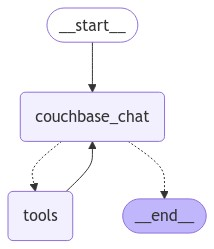

In [12]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("couchbase_chat", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "couchbase_chat",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "couchbase_chat")
graph_builder.add_edge(START, "couchbase_chat")
graph = graph_builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



In [13]:
message = graph.invoke({"messages": {"role": "user", "content": " Search flight details of the airline id 10123"}})
for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

 Search flight details of the airline id 10123
================================== Ai Message ==================================
Tool Calls:
  searchSQL (3286d5ef-8756-4825-9be3-706117ac38da)
 Call ID: 3286d5ef-8756-4825-9be3-706117ac38da
  Args:
    id: 10123
================================= Tool Message =================================
Name: searchSQL

[Document(page_content="airline: {'callsign': 'TXW', 'country': 'United States', 'iata': 'TQ', 'icao': 'TXW', 'id': 10123, 'name': 'Texas Wings', 'type': 'airline'}")]
================================== Ai Message ==================================

The flight details of the airline with ID 10123 are as follows:

* Callsign: TXW
* Country: United States
* IATA code: TQ
* ICAO code: TXW
* Name: Texas Wings
* Type: Airline


In [14]:
message = graph.invoke({"messages": {"role": "user", "content": "Explain Memory and network-centric architecture of couchbase"}})

for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

Explain Memory and network-centric architecture of couchbase
================================== Ai Message ==================================
Tool Calls:
  tools_cb_vector (853bbfd6-4eba-4018-85f4-4da06bef0b09)
 Call ID: 853bbfd6-4eba-4018-85f4-4da06bef0b09
  Args:
    query: Memory and network-centric architecture
================================= Tool Message =================================
Name: tools_cb_vector

[Document(page_content='17\nBecause the service supports efficient parallel query processing and bulk data handling, \nand runs on separate nodes, it is often preferable for expensive queries, even if the queries \nare predetermined and could be supported by an operational index. With traditional \ndatabase technology it is important to segregate operational and analytic workloads.  \nThis is usually done by batch exporting of data from operational databases into an analytic \ndatabase that d

In [15]:
message = graph.invoke({"messages": {"role": "user", "content": "Explain Couchbase architecture in hood and Fetch details of airline 10642 from couchbase bucket travel"}})

for m in message['messages']:
    m.pretty_print()

================================ Human Message =================================

Explain Couchbase architecture in hood and Fetch details of airline 10642 from couchbase bucket travel
================================== Ai Message ==================================
Tool Calls:
  tools_cb_vector (a108c8d7-54bd-446d-b6d1-b708639bf647)
 Call ID: a108c8d7-54bd-446d-b6d1-b708639bf647
  Args:
    query: 
  searchSQL (4ce006a2-fb9d-48e4-afa3-45b9bbd3d330)
 Call ID: 4ce006a2-fb9d-48e4-afa3-45b9bbd3d330
  Args:
    id: 10642
================================= Tool Message =================================
Name: tools_cb_vector

[Document(page_content='and will dramatically affect performance and make the cluster less resilient to denial of \nservice attacks.'), Document(page_content='is a robust and accessible set of features with solid performance and ease of management \nin a single NoSQL database. Learn more about how Couchbase delivers on these core \ndatabase requirements in the following t